:Image captioning is the task of predicting a caption for a given image. Common real world applications of it include aiding visually impaired people that can help them navigate through different situations. Therefore, image captioning helps to improve content accessibility for people by describing images to them.

This guide will show you how to:

Fine-tune an image captioning model.
Use the fine-tuned model for inference.

Before you begin, make sure you have all the necessary libraries installed:

In [13]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.1 MB/s eta 0:00:00


In [14]:
!pip install accelerate -U

In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.4 MB/s eta 0:00:00


We encourage you to log in to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to log in:

In [1]:
from huggingface_hub import notebook_login

notebook_login()

Load the Pokémon BLIP captions dataset

Use the 🤗 Dataset library to load a dataset that consists of {image-caption} pairs. To create your own image captioning dataset in PyTorch, you can follow this notebook.

In [2]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

The dataset has two features, image and text.

Many image captioning datasets contain multiple captions per image. In those cases, a common strategy is to randomly sample a caption amongst the available ones during training.

Split the dataset’s train split into a train and test set with the train_test_split method:

In [3]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

Let’s visualize a couple of samples from the training set.

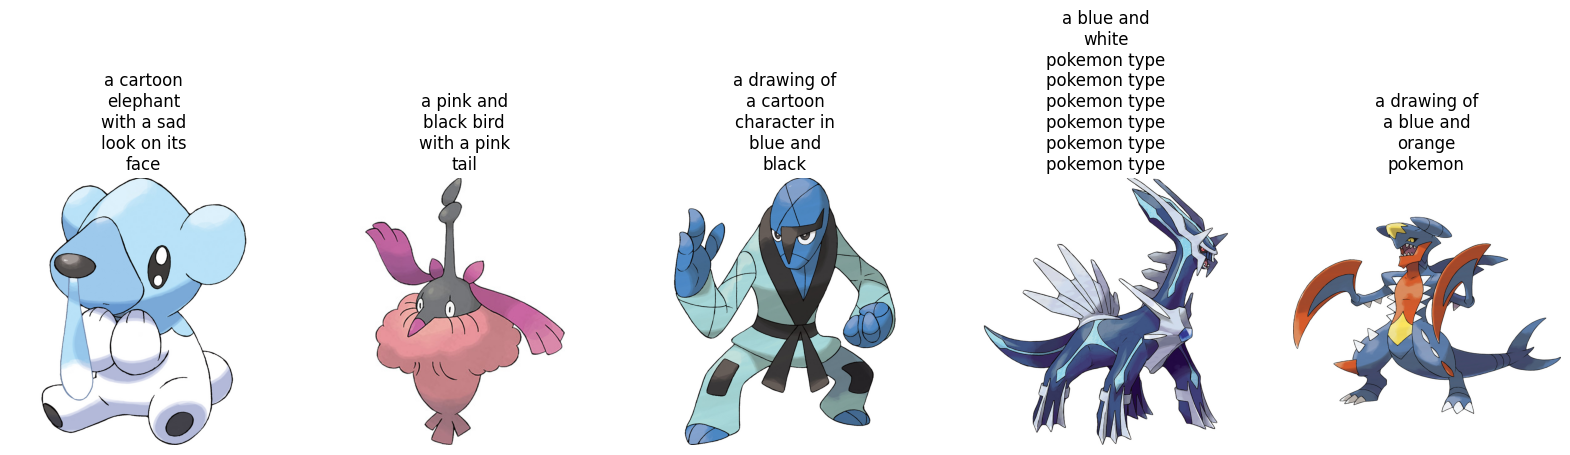

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

 Preprocess the dataset

Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

To do so, load the processor class associated with the model you are about to fine-tune.

In [5]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [6]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

With the dataset ready, you can now set up the model for fine-tuning.
Load a base model

Load the “microsoft/git-base” into a AutoModelForCausalLM object.

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

 Evaluate

Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. For this guide, you will use the Word Error Rate (WER).

We use the 🤗 Evaluate library to do so. For potential limitations and other gotchas of the WER, refer to this guide.

In [9]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

 Train!

Now, you are ready to start fine-tuning the model. You will use the 🤗 Trainer for this.

First, define the training arguments using TrainingArguments.

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

Then pass them along with the datasets and the model to 🤗 Trainer.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

To start training, simply call train() on the Trainer object.

In [ ]:
trainer.train()

You should see the training loss drop smoothly as training progresses.

Once training is completed, share your model to the Hub with the push_to_hub() method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

 Inference

Take a sample image from test_ds to test the model.

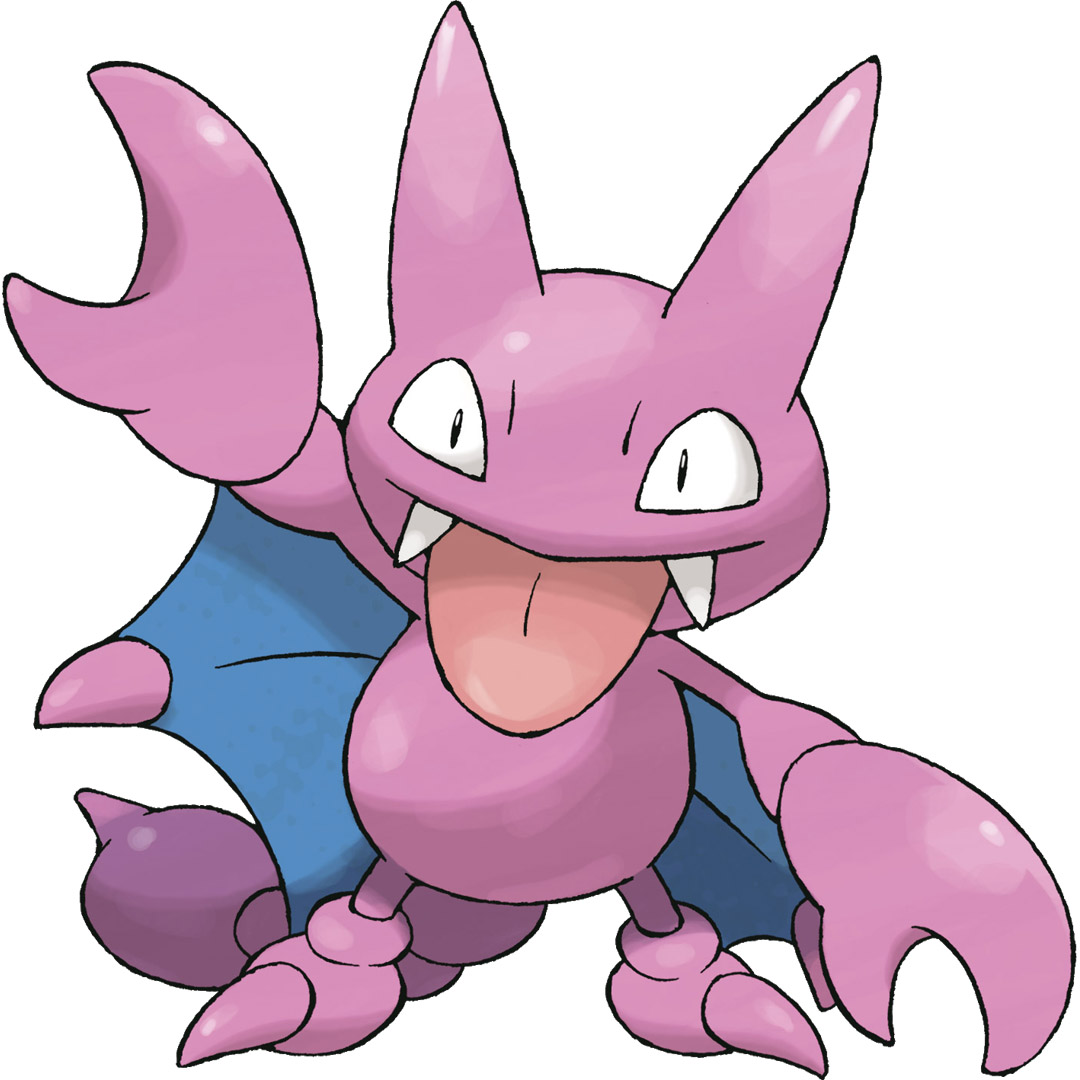

In [11]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

 Prepare image for the model.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Call generate and decode the predictions.

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)